In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import yahoo_fin.stock_info as si
import pandas_datareader.data as reader
import time 
from tqdm import tqdm_notebook as tqdm
import warnings
from typing_extensions import Literal
import pqr
warnings.filterwarnings('ignore')

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [5]:
fang = si.tickers_sp500()
ticks = [yf.Ticker(ticker) for ticker in fang]

close_price_us = pd.DataFrame()
start = '2010-01-01'
end = '2021-01-01'

for i, ticker in enumerate(ticks):
        close_price_us['close_of_{}'.format(i)] = ticker.history(start = start, end = end, interval = '3mo')['Close']

close_price_us.columns = fang

close_price_us = close_price_us.fillna(method = 'ffill').dropna(axis = 1)

return_us = pd.DataFrame()

for ticker in close_price_us.columns:
        return_us[ticker] = (close_price_us[ticker] - close_price_us[ticker].shift(1)) / close_price_us[ticker].shift(1)
        
return_us = return_us.dropna()
return_us.index = return_us.index.to_period('M')

# загрузка факторов с сайта и их масштабирование 
ff_factors = reader.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0] / 100

merged = return_us.merge(ff_factors, how = 'left', on = 'Date')

$CEG: possibly delisted; no price data found  (3mo 2020-01-01 -> 2021-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577854800, endDate = 1609477200")
$GEHC: possibly delisted; no price data found  (3mo 2020-01-01 -> 2021-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577854800, endDate = 1609477200")
$GEV: possibly delisted; no price data found  (3mo 2020-01-01 -> 2021-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577854800, endDate = 1609477200")
$KVUE: possibly delisted; no price data found  (3mo 2020-01-01 -> 2021-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577854800, endDate = 1609477200")
$SOLV: possibly delisted; no price data found  (3mo 2020-01-01 -> 2021-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577854800, endDate = 1609477200")
$SW: possibly delisted; no price data found  (3mo 2020-01-01 -> 2021-01-01) (Yahoo error = "Data doesn't exist for startDate = 1577854800, endDate = 1609477200")
$VLTO: possibly deli

In [10]:
# цены американских акций
path = 'C:\\Users\\admin\\anaconda3\\вкр_расчеты\\S&P 500 Tikers(Final).xlsx'
prices = pd.read_excel(path, sheet_name='Цена 2010-2019', index_col=0, skiprows=3)[1:]

# капитализация компаний
mkap = pd.read_excel(path, sheet_name='Market cap 2010-2019', index_col=0, skiprows=3)[1:]

# балансовая стоимость
mv_to_bv = pd.read_excel(path, sheet_name='MV-BV 2010-2019', index_col=0, skiprows=3)[1:]
mv_to_bv.fillna(0, inplace=True)

In [11]:
# строим бенчмарк
universe = prices.notnull()
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns,
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [12]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
    ),
    multiplier=100,
    precision=2,
    name="Sharp Ratio",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.sortino_ratio,
    ),
    multiplier=100,
    precision=2,
    name="Sortino Ratio",
)
fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    log_scale=True,
    kwargs={
        "figsize": (10, 6),
    }
)

summary = pqr.metrics.Dashboard([table, fig])

## momentum factor 

In [13]:
dynamic_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_pct_change, period=12),
    pqr.utils.partial(pqr.factors.hold, period=12)
)
mom = dynamic_transform(prices)

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
"Monthly Mean Return, %",1.12*** (2.87),0.90*** (2.75),0.90*** (3.17),0.75*** (2.68),0.47 (0.98)
"Monthly Volatility, %",4.04,3.39,2.93,2.91,4.99
"Maximum Drawdown, %",-23.40,-18.69,-18.00,-16.62,-32.90
"Monthly Mean Excess Return, %",0.24* (1.49),0.02 (0.19),0.02 (0.13),-0.13 (-1.01),-0.41 (-1.66)
"Monthly Alpha, %",0.18 (1.11),0.09 (0.77),0.21* (1.88),0.06 (0.60),-0.64*** (-2.72)
"Monthly Beta, %",1.06*** (22.91),0.93*** (29.47),0.78*** (25.10),0.79*** (26.72),1.27*** (19.05)
Sharp Ratio,96.14,92.07,106.24,89.77,32.83
Sortino Ratio,167.61,153.86,189.64,152.55,47.99


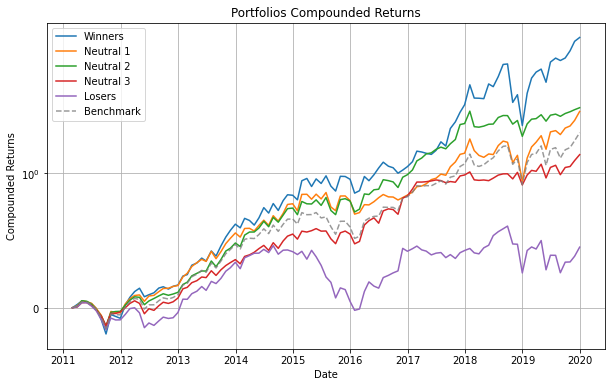

In [14]:
portfolios_q = pqr.factors.backtest_factor_portfolios(
    factor=mom,
    strategies=pqr.factors.split_quantiles(5, "more"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

summary.display(portfolios_q)

In [15]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.look_back_mean, period=3),
    pqr.utils.partial(pqr.factors.hold, period=3),
)

value = mean_transform(mv_to_bv)
size = mean_transform(mkap)

## value factor 

In [79]:
portfolios = pqr.factors.backtest_factor_portfolios(
    factor=value,
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=True,
)

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",0.80** (2.11),0.97*** (2.89),1.20*** (3.74),-0.40 (-2.20)
"Monthly Volatility, %",4.09,3.63,3.46,1.97
"Maximum Drawdown, %",-21.81,-19.87,-15.99,-40.71
"Monthly Mean Excess Return, %",-0.13 (-1.08),0.04 (0.55),0.27*** (2.60),-1.33 (-3.94)
"Monthly Alpha, %",-0.17 (-1.41),0.09 (1.14),0.38*** (3.73),-0.55*** (-3.05)
"Monthly Beta, %",1.05*** (32.83),0.95*** (47.29),0.89*** (33.38),0.16*** (3.37)
Sharp Ratio,67.83,92.84,120.34,-70.85
Sortino Ratio,109.35,157.15,217.96,-91.93


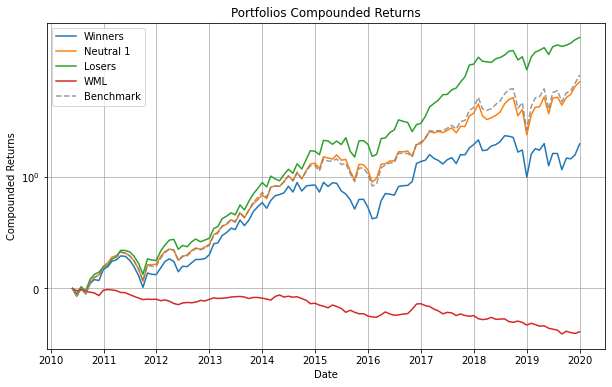

In [80]:
summary.display(portfolios)

## size factor 

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.06*** (2.75),0.96*** (2.92),0.96*** (3.03),0.10 (0.63)
"Monthly Volatility, %",4.14,3.53,3.40,1.68
"Maximum Drawdown, %",-20.27,-18.79,-18.60,-22.14
"Monthly Mean Excess Return, %",0.13 (1.15),0.03 (0.36),0.03 (0.29),-0.83 (-2.64)
"Monthly Alpha, %",0.06 (0.55),0.09 (1.29),0.14 (1.56),-0.08 (-0.51)
"Monthly Beta, %",1.07*** (37.08),0.93*** (48.88),0.88*** (38.79),0.19*** (4.85)
Sharp Ratio,88.31,93.80,97.32,20.38
Sortino Ratio,148.51,158.40,164.19,29.51


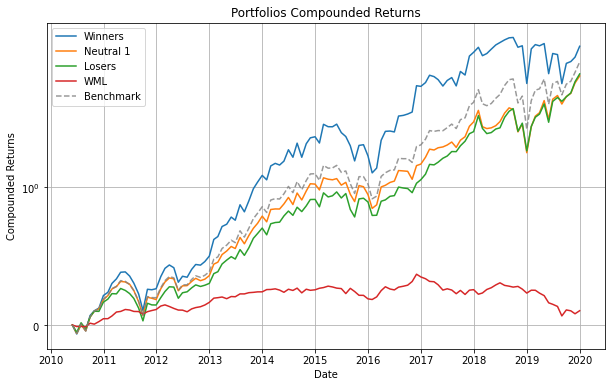

In [81]:
portfolios = pqr.factors.backtest_factor_portfolios(
    factor=size,
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=True,
)

summary.display(portfolios)